In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../figures")

from what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test

In [4]:
from main import init
args = init(filename='../data/2019-06-05')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True}

## Unit tests

In [5]:
transform=transforms.Compose([
                               WhatShift(i_offset=-8, j_offset=8),
                               WhatBackground(),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

In [6]:
dataset_train = datasets.MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

In [7]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [8]:
dataset_test = datasets.MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [ ]:
data, label = next(iter(train_loader))

In [ ]:
label.shape

torch.Size([100])

Text(0.5, 1.0, 'label : 9')

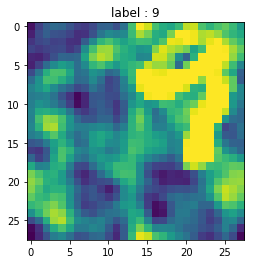

In [ ]:
i = 5
plt.imshow(data[i,:,:].detach().numpy().reshape((28, 28)))
plt.title('label : '+str(label[i].item()))

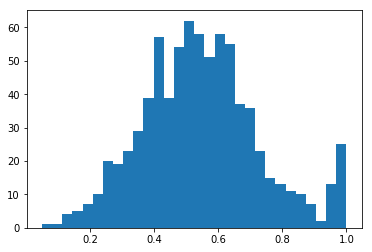

In [ ]:
h = plt.hist(data[1,:,:].detach().numpy().flatten(), 30)

In [ ]:
device = 'cpu'
model = WhatNet().to(device)
loss_func = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
if False:
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, loss_func, optimizer, epoch)
        test(args, model, device, test_loader)

## WhatTrainer Class test

In [24]:
whatTrainer = WhatTrainer(args=args)

In [25]:
if False:
    for epoch in range(2, args.epochs + 1):
        whatTrainer.train(epoch)
        whatTrainer.test()

## What class test

In [5]:
args.epochs = 1
args.save_model = True
what = What(args=args, force= True)

Train Epoch: 1/1 [0/60000 (0%)]	Loss: 2.304661
Train Epoch: 1/1 [10000/60000 (17%)]	Loss: 2.295348
Train Epoch: 1/1 [20000/60000 (33%)]	Loss: 1.541447
Train Epoch: 1/1 [30000/60000 (50%)]	Loss: 1.372754
Train Epoch: 1/1 [40000/60000 (67%)]	Loss: 0.852919
Train Epoch: 1/1 [50000/60000 (83%)]	Loss: 0.765395

Test set: Average loss: 0.7575, Accuracy: 7456/10000 (75%)



In [6]:
model = torch.load("../data/MNIST_cnn_0.1_0.1_1.0_0.7.pt")
for i_offset in range(-1,2):
    for j_offset in range(-1,2):
        transform=transforms.Compose([
                               WhatShift(i_offset=i_offset, j_offset=j_offset),
                               WhatBackground(),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])
        dataset_test = datasets.MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )
        test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)
        whatTrainer = WhatTrainer(args, model = model, test_loader = test_loader)
        acc = whatTrainer.test()
        print(acc)
        


Test set: Average loss: 1.1749, Accuracy: 6401/10000 (64%)

0.6401

Test set: Average loss: 0.7732, Accuracy: 7453/10000 (75%)

0.7453

Test set: Average loss: 0.7906, Accuracy: 7353/10000 (74%)

0.7353

Test set: Average loss: 0.7773, Accuracy: 7502/10000 (75%)

0.7502

Test set: Average loss: 0.5955, Accuracy: 8064/10000 (81%)

0.8064

Test set: Average loss: 0.7614, Accuracy: 7572/10000 (76%)

0.7572

Test set: Average loss: 0.7308, Accuracy: 7688/10000 (77%)

0.7688

Test set: Average loss: 0.7110, Accuracy: 7790/10000 (78%)

0.779

Test set: Average loss: 1.1131, Accuracy: 6619/10000 (66%)

0.6619


## Petit réseau secondaire et définition accuracy map

In [11]:
# Tuto : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

plt.ion()   # interactive mode

In [20]:
nb_classes = 10

In [33]:
"""
# import MNIST repris de TP1 Artières

Dtest=pd.read_csv("C:/Users/Marion/Desktop/test.csv")
Dtest=Dtest.values

x_testV = Dtest
print(len(Dtest))
y_testV = Dtest[:,0]

x_testV = x_testV.astype('float32') / 255. # pour se ramener entre 0 et 1, et convertit d'abord le type d'entier à flottant
x_testV = x_testV.reshape((len(x_testV), len(x_testV[0]))) # 28x28=784 une image = vecteur de 784 coordonnees

#Y_testV = y_test



y_testV = to_categorical(y_testV, nb_classes) #  transforme par exemple la classe 5 en [0000010000] <- one-hot-code cf cours 2 de Artieres

print(x_testV)
#print(x_testV[0])
print(len(x_testV[0]))
print(x_testV.shape)
"""
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]



Dtrain=pd.read_csv("C:/Users/Marion/Desktop/train.csv",header=1)
Dtrain=Dtrain.values

x_train = Dtrain[:,1:]
y_train = Dtrain[:,0]

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # 28x28=784 une image = vecteur de 784 coordonnees

Y_train = y_train
y_train =  to_categorical(y_train, nb_classes) # transforme par exemple la classe 5 en [0000010000] <- one-hot-code cf cours 2 de Artieres


Image numéro : 20870
Valeur attendue : 0


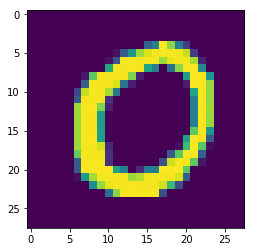

In [40]:
nb = np.random.randint(x_train.shape[0])
print("Image numéro :", nb)
print("Valeur attendue :", np.argmax(y_train[nb]))
plt.imshow(x_train[nb].reshape(28,28))

In [26]:
# repris du tuto

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
# repris du tuto

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
# repris du tuto

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------


NameError: name 'dataloaders' is not defined